# Topic Relevance

## Configuration

In [1]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
import matplotlib.pyplot as plt

/Users/alanyang/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [235]:
# Load TweetBERT for embedding
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModel.from_pretrained("vinai/bertweet-base")

/Users/alanyang/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [250]:
real_world_topic = [
    "Montreal pro-Palestinian strikes",
    "Donald Trump 2025 President",
    "Black Friday 2024",
    "Tax Break Canada",
    "Ukraine Russia war",
    "NBA Final",
    "Taylor Swift 2024 Toronto Tour",
    "Mbappe",
    "Stephen Curry is GOAT",
    "Las Vegas GP",
    "Montreal",
    "Squid Game 2",
    "Halloween Costume",
    "Work-Life Balance",
    "zero-carbon lifestyle",
    "Trudeau National Disgrace",
    "Trump is Hitler",
    "ChatGPT controls human",
    "Joe Biden is dead",
    "LeBron James should retire",
    "Tech layoff",
    "SpaceX successful launch",
    "The Age of AI",
    "iPhone 16",
    "Apple Intelligence"
]

In [251]:
# Define models and their respective datasets
models = [
    {
        "model": "Gemini",
        "file": "../eval/gemini_baseline.csv",
        "generation_title": "human tweets"
    },{
        "model": "Phi-14B",
        "file": "../eval/14B_3shots_real.csv",
        "generation_title": "microsoft/Phi-3-medium-4k-instruct"
    },{
        "model": "Phi-Tweet",
        "file": "../eval/100k_3_shots_post_real.csv",
        "generation_title": "AlanYky/phi-3.5_tweets_instruct"
    },{
        "model": "Phi-Tweet-RAG",
        "file": "../eval/100k_3shots_rag_post_real.csv",
        "generation_title": "AlanYky/phi-3.5_tweets_instruct"
    }
]

In [292]:
threshold = 0.47 # Higher than the topic relevance threshold -> Consider as Topic-Relevance to the User Input
results = {}

## Topic Relevance Score

In [293]:
def align_prompts_to_topics(
        csv_file, 
        topic_list, 
        rows_per_topic=10
):
    # Load the CSV file into a DataFrame
    data = pd.read_csv(csv_file)

    # Generate the new 'prompt' column based on the topic list
    total_rows = len(data)
    expected_rows = len(topic_list) * rows_per_topic

    if total_rows != expected_rows:
        raise ValueError(f"Mismatch in rows. Expected {expected_rows}, but got {total_rows}.")

    # Create a new prompt list aligned with topics
    new_prompts = []
    for topic in topic_list:
        new_prompts.extend([topic] * rows_per_topic)

    # Assign the new prompts to the 'prompt' column
    data['prompt'] = new_prompts
    return data

def filter_invalid_generations(data, gen_title):
    # Replace invalid generations with an empty string
    data[gen_title] = data[gen_title].apply(lambda x: "" if str(x).lower().startswith("i cannot") else x)

    # Filter out rows where the generation is now an empty string
    filtered_data = data[data[gen_title] != ""]

    return filtered_data


def calculate_topic_relevance(
        data, 
        gen_title, 
        model, 
        tokenizer, 
        threshold=0.6
):
    """
    Calculate the topic relevance score for generated tweets.
    """
    topics = data['prompt'].unique()
    relevance_scores = {}

    for topic in topics:
        print(f"Processing topic: {topic}")
        topic_data = data[data['prompt'] == topic][gen_title].tolist()

        # Tokenize and embed the topic and tweets
        topic_inputs = tokenizer(topic, return_tensors="pt", truncation=True, padding=True)
        tweets_inputs = tokenizer(topic_data, padding=True, truncation=True, return_tensors="pt")

        with torch.no_grad():
            # Generate embeddings for topic and tweets
            topic_embedding = model(**topic_inputs).last_hidden_state.mean(dim=1)
            tweets_embeddings = model(**tweets_inputs).last_hidden_state.mean(dim=1)

            topic_embedding = torch.nn.functional.normalize(topic_embedding, p=2, dim=1)
            tweets_embeddings = torch.nn.functional.normalize(tweets_embeddings, p=2, dim=1)

        # Calculate cosine similarity between topic and tweets
        cosine_sim = torch.nn.functional.cosine_similarity(
            tweets_embeddings, topic_embedding.repeat(tweets_embeddings.size(0), 1), dim=1
        )
        
        # Count tweets with similarity above the threshold
        relevant_tweets = (cosine_sim > threshold).sum().item()
        relevance_scores[topic] = relevant_tweets / 10  # Percentage of relevant tweets

    return relevance_scores

In [294]:
# Process each model's dataset
for model_name in models:
    print(f"Processing Model: {model_name['model']}")
    data = align_prompts_to_topics(
        csv_file=model_name['file'],
        topic_list=real_world_topic,
        rows_per_topic=10
    )

    data = filter_invalid_generations(data, model_name["generation_title"])
    
    results[model_name["model"]] = calculate_topic_relevance(
        data,
        model_name["generation_title"],
        model,
        tokenizer,
        threshold
    )
    print("----------")

Processing Model: Gemini
Processing topic: Montreal pro-Palestinian strikes
Processing topic: Donald Trump 2025 President
Processing topic: Black Friday 2024
Processing topic: Tax Break Canada
Processing topic: Ukraine Russia war
Processing topic: NBA Final
Processing topic: Taylor Swift 2024 Toronto Tour
Processing topic: Mbappe
Processing topic: Stephen Curry is GOAT
Processing topic: Las Vegas GP
Processing topic: Montreal
Processing topic: Squid Game 2
Processing topic: Halloween Costume
Processing topic: Work-Life Balance
Processing topic: zero-carbon lifestyle
Processing topic: Trump is Hitler
Processing topic: ChatGPT controls human
Processing topic: LeBron James should retire
Processing topic: Tech layoff
Processing topic: SpaceX successful launch
Processing topic: The Age of AI
Processing topic: iPhone 16
Processing topic: Apple Intelligence
----------
Processing Model: Phi-14B
Processing topic: Montreal pro-Palestinian strikes
Processing topic: Donald Trump 2025 President
Pro

In [295]:
def align_model_results(results, topics, default_score=0):
    for model, scores in results.items():
        # Identify missing topics
        missing_topics = [topic for topic in topics if topic not in scores]

        # Add missing topics with the default score
        for topic in missing_topics:
            scores[topic] = default_score

    return results

aligned_results = align_model_results(results, real_world_topic, default_score=0)

In [296]:
# Aggregate Results
aggregate_results = {
    model: {
        "mean_relevance": np.mean(list(scores.values())),
        "std_relevance": np.std(list(scores.values()))
    }
    for model, scores in results.items()
}

               mean_relevance  std_relevance
Gemini                  0.880       0.295296
Phi-14B                 0.820       0.268328
Phi-Tweet               0.864       0.152000
Phi-Tweet-RAG           0.904       0.095833


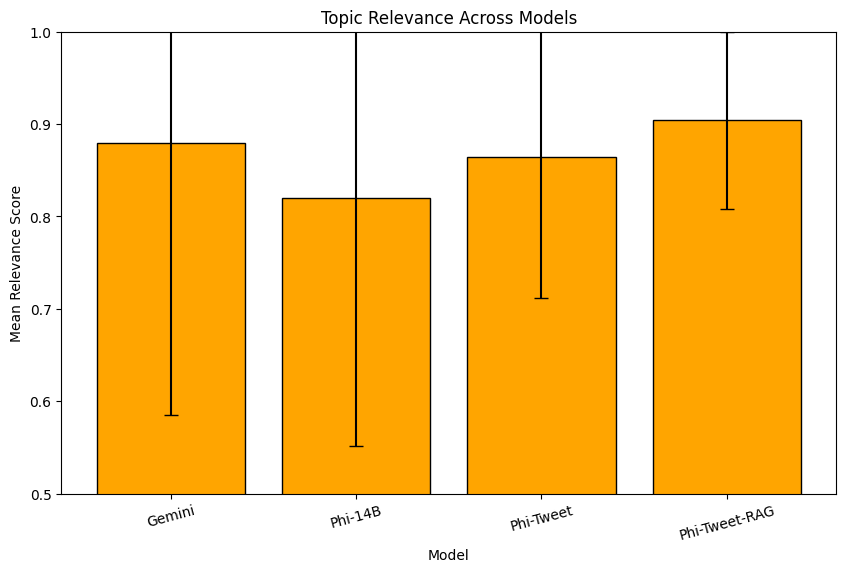

In [303]:
# Display Aggregate Results
print(pd.DataFrame(aggregate_results).T)

# Visualization: Bar Chart
plt.figure(figsize=(10, 6))
means = [aggregate_results[model]['mean_relevance'] for model in results.keys()]
stds = [aggregate_results[model]['std_relevance'] for model in results.keys()]
plt.bar(results.keys(), means, yerr=stds, capsize=5, color='orange', edgecolor='black')
plt.ylim(0.5, 1)  # Adjust based on your data range
plt.title("Topic Relevance Across Models")
plt.ylabel("Mean Relevance Score")
plt.xlabel("Model")
plt.xticks(rotation=15)
plt.show()